In [229]:
import pandas as pd
import numpy as np
import functools
from datetime import datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import pprint
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
pd.set_option('display.float_format', lambda x: '%.5f' % x)


client = CoinMetricsClient('FeHRFvBh9VfW6an1UgbM')

In [5]:
@functools.lru_cache(maxsize=16)
def get_data(exchange, market, start_date, end_date):
    """
    :param exchange: coinbase, binance, etc.
    :param market: btc, eth, etc.
    :param start_date: start date of the asset's pricing information. format --> '%Y-%m-%d'
    :param end_date: end date of the asset's pricing information in same format as start date
    :return: returns a dataframe of the security, indexed by date, in the given date range
    
    """
    data = client.get_market_trades(
        markets = f"{exchange}-{market}-usdt-spot", 
        start_time = start_date, 
        end_time = end_date, 
        end_inclusive = False
        ).to_dataframe()

    data.set_index('time', inplace=True)
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)
    
    if data.duplicated().sum() > 0:
        data.drop_duplicates(keep='first', inplace=True)
    
    return data\

#Helper function to pull 15 minute data 
#Returns a list of dates to input into API pull
def datetime_range(start, end, delta):
    current = start
    while current < end: 
        yield current
        current += delta

In [7]:
#Pull 7 days worth of data at a time
dates = [dt.strftime('%Y-%m-%d') for dt in datetime_range(datetime(2022, 1, 1), datetime(2022, 3, 31), timedelta(days=7))]
dates.append((datetime(2022,3,31)).strftime('%Y-%m-%d'))
dates

['2022-01-01',
 '2022-01-08',
 '2022-01-15',
 '2022-01-22',
 '2022-01-29',
 '2022-02-05',
 '2022-02-12',
 '2022-02-19',
 '2022-02-26',
 '2022-03-05',
 '2022-03-12',
 '2022-03-19',
 '2022-03-26',
 '2022-03-31']

In [92]:
tickData = pd.DataFrame()
#Pull 7 days worth of data at a time and append to dataframe
for idx, _ in enumerate(dates[:-1]):
    data = get_data('coinbase', 'eth', dates[idx], dates[idx+1])
    tickData = pd.concat([tickData, data])
    print(f'{dates[idx]} to {dates[idx+1]} done. \n')

2022-01-01 to 2022-01-08 done. 

2022-01-08 to 2022-01-15 done. 

2022-01-15 to 2022-01-22 done. 

2022-01-22 to 2022-01-29 done. 

2022-01-29 to 2022-02-05 done. 

2022-02-05 to 2022-02-12 done. 

2022-02-12 to 2022-02-19 done. 

2022-02-19 to 2022-02-26 done. 

2022-02-26 to 2022-03-05 done. 

2022-03-05 to 2022-03-12 done. 

2022-03-12 to 2022-03-19 done. 

2022-03-19 to 2022-03-26 done. 

2022-03-26 to 2022-03-31 done. 



In [93]:
#We want to track daily notional
tickData['notional'] = tickData['amount'] * tickData['price']

In [94]:
tickData = tickData[['notional']]

In [95]:
tickData = tickData.resample('1h', label = 'right').sum().fillna(0)

In [96]:
tickData

,notional
time,
2022-01-01 01:00:00+00:00,599099.231335
2022-01-01 02:00:00+00:00,910528.442194
2022-01-01 03:00:00+00:00,594479.031262
2022-01-01 04:00:00+00:00,193658.056912
2022-01-01 05:00:00+00:00,319609.209951
...,...
2022-03-30 20:00:00+00:00,1652302.146272
2022-03-30 21:00:00+00:00,803029.601588
2022-03-30 22:00:00+00:00,848615.659668


In [224]:
snapshotDates = [dt.strftime('%Y-%m-%dT%H:%M:%S') for dt in datetime_range(datetime(2022, 1, 2, 1, 0, 0), datetime(2022, 3, 31), timedelta(hours=1))]
#snapshotDates = [pd.to_datetime(i, utc=True) for i in snapshotDates]
snapshotDates[:5]

['2022-01-02T01:00:00',
 '2022-01-02T02:00:00',
 '2022-01-02T03:00:00',
 '2022-01-02T04:00:00',
 '2022-01-02T05:00:00']

In [189]:
book = client.get_market_orderbooks('coinbase-eth-usdt-spot', start_time = '2022-01-02T01:00:00', end_time = '2022-01-02T01:00:00').to_dataframe()

In [190]:
book

,market,time,coin_metrics_id,asks,bids,database_time
0,coinbase-eth-usdt-spot,2022-01-02 01:00:00+00:00,1641085200000000-0,"[{'price': '3762.43', 'size': '0.38167412'}, {...","[{'price': '3761.51', 'size': '0.26578997'}, {...",2022-01-02 01:01:51.012265+00:00


### Unfortunately, the book data is in the form of a string, so we need to do a bit of string manipulation to build the book.

In [191]:
book['asks'][0]

"[{'price': '3762.43', 'size': '0.38167412'}, {'price': '3762.44', 'size': '0.098'}, {'price': '3762.45', 'size': '1.6261758'}, {'price': '3762.46', 'size': '0.35326508'}, {'price': '3762.47', 'size': '0.50974504'}, {'price': '3762.48', 'size': '0.69380369'}, {'price': '3762.49', 'size': '0.81839104'}, {'price': '3762.5', 'size': '0.26578837'}, {'price': '3762.55', 'size': '0.66870294'}, {'price': '3762.79', 'size': '0.29744'}, {'price': '3763.09', 'size': '1.04447493'}, {'price': '3763.1', 'size': '6.04500302'}, {'price': '3763.11', 'size': '7.54198819'}, {'price': '3763.22', 'size': '7.90461241'}, {'price': '3763.72', 'size': '1.99339364'}, {'price': '3764.06', 'size': '3.54432242'}, {'price': '3764.07', 'size': '2.08134926'}, {'price': '3764.11', 'size': '3.40286248'}, {'price': '3764.12', 'size': '0.55489809'}, {'price': '3764.22', 'size': '1.89900006'}, {'price': '3764.23', 'size': '4.78'}, {'price': '3764.35', 'size': '3'}, {'price': '3764.47', 'size': '1.52598258'}, {'price': '3

In [192]:
def BuildBook(book):
    asks = book['asks'][0]
    bids = book['bids'][0]
    
    remove = "[{:,}]'"
    for character in remove:
        asks = asks.replace(character, "")
        bids = bids.replace(character, "")
    
    askList = asks.split(' ')
    bidList = bids.split(' ')
    
    askBook = pd.DataFrame()
    bidBook = pd.DataFrame()
    
    askBook['price'] = [float(i) for i in askList[1::4]]
    askBook['quantity'] = [float(i) for i in askList[3::4]]
    
    bidBook['price'] = [float(i) for i in bidList[1::4]]
    bidBook['quantity'] = [float(i) for i in bidList[3::4]]
    
    askBook['notional'] = askBook['price'] * askBook['quantity']
    bidBook['notional'] = bidBook['price'] * bidBook['quantity']
    
    return askBook, bidBook

In [194]:
asks, bids = BuildBook(book)

In [197]:
asks[:5]

,price,quantity,notional
0,3762.43000,0.38167,1436.02216
1,3762.44000,0.09800,368.71912
2,3762.45000,1.62618,6118.40514
3,3762.46000,0.35327,1329.14573
4,3762.47000,0.50975,1917.90042


In [198]:
bids[:5]

,price,quantity,notional
0,3761.51000,0.26579,999.77163
1,3760.98000,0.66446,2499.03788
2,3760.97000,0.06400,240.70208
3,3760.79000,0.35372,1330.26803
4,3760.77000,0.13397,503.84769


In [202]:
snapshotDates[0] - pd.Timedelta(1, 'd')

Timestamp('2022-01-01 01:00:00+0000', tz='UTC')

In [203]:
#snapshotDates[0] + pd.Timedelta(1, 'd')
oneP = tickData.loc[(snapshotDates[0] - pd.Timedelta(1, 'd')):(snapshotDates[0]-pd.Timedelta(1, 'h'))].sum() * 0.01

In [204]:
avgCostAsks = 0
pos = oneP[0]
for idx, notional in enumerate(asks['notional']):
    while pos > 0:
        if pos - notional > 0:
            wt = notional / oneP
            pos -= notional
            avgCostAsks += wt * asks.loc[idx, 'price']
        else:
            pos-= notional
            newNotional = notional + pos
            wt = newNotional / oneP
            avgCostAsks += wt * asks.loc[idx, 'price']

In [205]:
avgCostAsks

notional   3762.43000
dtype: float64

In [208]:
avgCostBids = 0
pos = oneP[0]
for idx, notional in enumerate(bids['notional']):
    while pos > 0:
        if pos - notional > 0:
            wt = notional / oneP
            pos -= notional
            avgCostBids += wt * bids.loc[idx, 'price']
        else:
            pos-= notional
            newNotional = notional + pos
            wt = newNotional / oneP
            avgCostBids += wt * bids.loc[idx, 'price']

In [209]:
avgCostBids

notional   3761.51000
dtype: float64

In [218]:
eta = (avgCostAsks - avgCostBids) / avgCostAsks

In [222]:
round(eta[0], 5)

0.00024

### As we can see, trading at 1% of the market would yield a cost of 2.4 basis points. Now lets calculate eta over every day in the sample period.

In [252]:
tradingCosts = []

for date in snapshotDates:
    book = client.get_market_orderbooks('coinbase-eth-usdt-spot', 
                                         start_time = date, 
                                         end_time = date).to_dataframe()
    
    date = pd.to_datetime(date, utc = True)
    
    askBook, bidBook = BuildBook(book)
    oneP = (tickData.loc[(date - pd.Timedelta(1, 'd')):(date - pd.Timedelta(1, 'h'))].sum() * 0.01)[0]
    
    avgCostAsks = 0
    askPos = oneP
    
    avgCostBids = 0
    bidPos = oneP
    
    askSwitch = True
    bidSwitch = True
    
    for idx, notional in enumerate(askBook['notional']):
        if askSwitch:
            if askPos - notional > 0:
                wt = notional / oneP
                askPos -= notional
                avgCostAsks += wt * askBook.loc[idx, 'price']
            else:
                askPos-= notional
                newNotional = notional + askPos
                wt = newNotional / oneP
                avgCostAsks += wt * askBook.loc[idx, 'price']
                askSwitch = False
        else:
            break
                
    for idx, notional in enumerate(bidBook['notional']):
        if bidSwitch:
            if bidPos - notional > 0:
                wt = notional / oneP
                bidPos -= notional
                avgCostBids += wt * bidBook.loc[idx, 'price']
            else:
                bidPos-= notional
                newNotional = notional + bidPos
                wt = newNotional / oneP
                avgCostBids += wt * bidBook.loc[idx, 'price']
                bidSwitch = False
        else:
            break
                
    eta = (avgCostAsks - avgCostBids) / avgCostAsks
    tradingCosts.append(eta)

In [253]:
tradingCosts

[0.000815431512454184,
 0.0008514810572145497,
 0.0008832478073082515,
 0.0008730738036613645,
 0.000977846642845838,
 0.0009163408647641491,
 0.0009584205554059561,
 0.0008783206217496892,
 0.0008685266091039602,
 0.0008361700941631792,
 0.00092075187033724,
 0.000803353456633375,
 0.0007761167598793011,
 0.0007905735937202841,
 0.000806178421524957,
 0.0009014457660015923,
 0.0012069971616140505,
 0.0009982521435473967,
 0.0012593481409533137,
 0.0008834410968715408,
 0.0009513859013249886,
 0.0008358637401967852,
 0.0010089858443832005,
 0.001343303214869032,
 0.0009505155248556323,
 0.001025416183451657,
 0.0009680469224503307,
 0.0010589071445606922,
 0.0010201933724391086,
 0.0009286763785199505,
 0.0009441145365528733,
 0.0006083719905356672,
 0.0006620886247542034,
 0.0008495799653721794,
 0.0010019374645507601,
 0.0009402957244203138,
 0.0011036186812994134,
 0.0011491581805488026,
 0.0010255960691671927,
 0.001107696468770673,
 0.0015109490783922102,
 0.0008727541072592461,
 

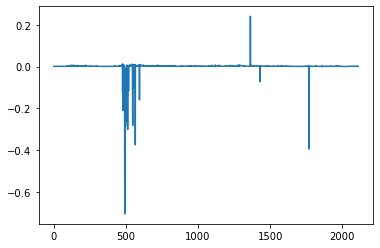

In [255]:
plt.plot(tradingCosts)